# 14.1 Отбор признаков

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

ds = fetch_california_housing()
X, y = ds.data, ds.target

indexes = np.arange(len(y))
np.random.seed(52342)
np.random.shuffle(indexes)

X = X[indexes, :]
y = y[indexes]

Отбор по корреляции

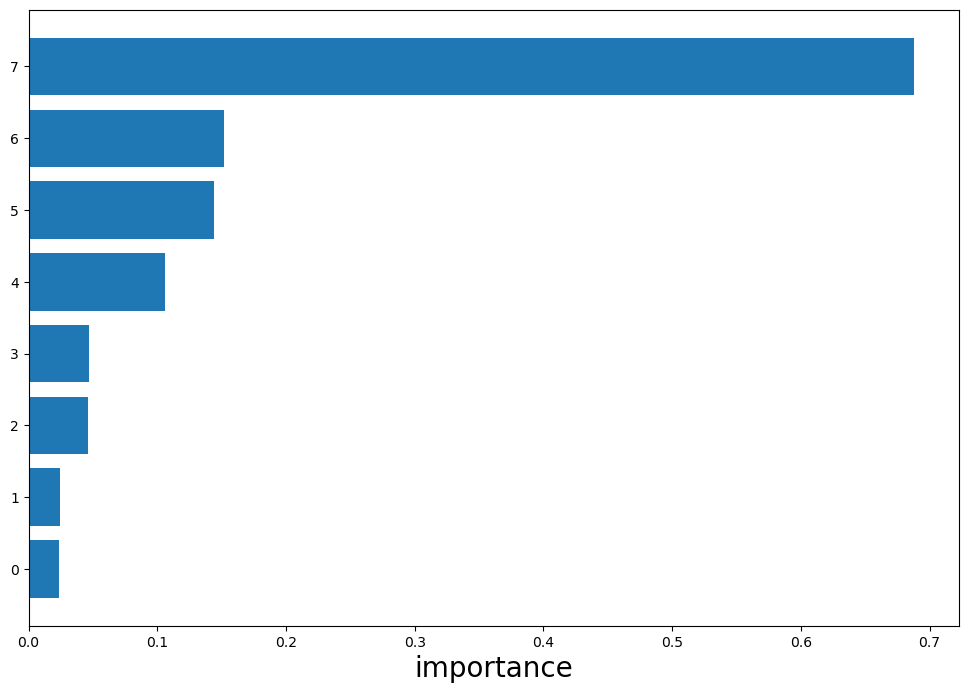

In [3]:
features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)

fig = plt.figure(figsize=(12,8))
plt.barh(features_ind, corrs[importances_sort])
plt.xlabel('importance', fontsize=20)
X = X[:, importances_sort]

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

features_counts = np.arange(X.shape[1])

def scores_by_cnt(reg):
    scores = []
    for features_part in tqdm(features_counts):
        X_part = X[:,importances_sort[features_part:]]
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


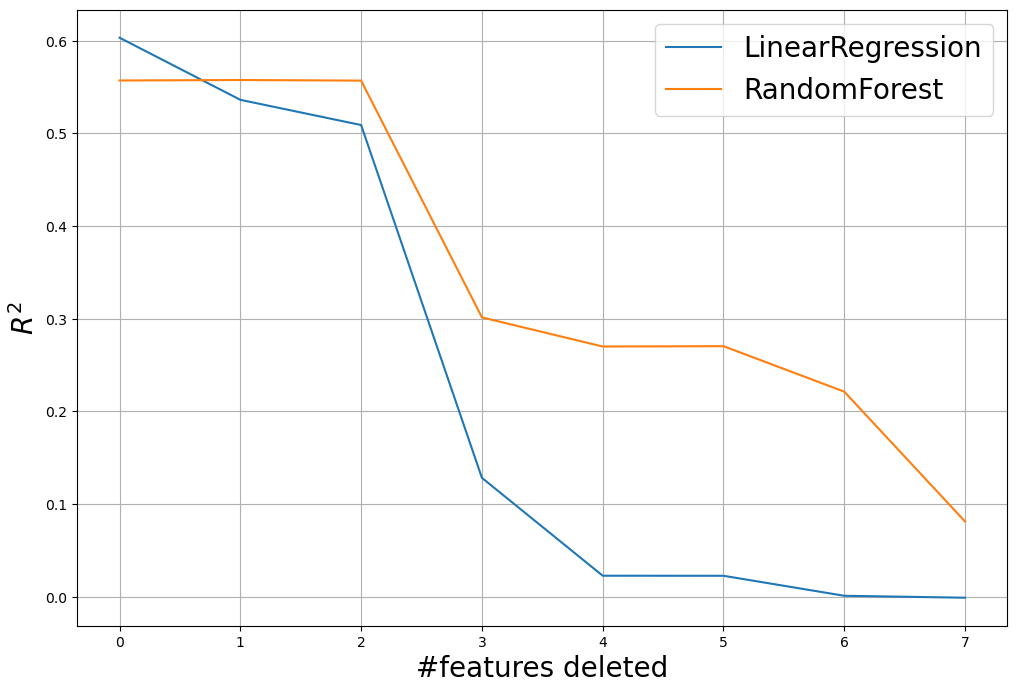

In [5]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Отбор по взаимной информации

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

select = SelectKBest(score_func=mutual_info_regression, k='all')
z = select.fit_transform(X, y)

importances_sort = np.argsort(select.scores_)

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:14<00:00,  1.87s/it]


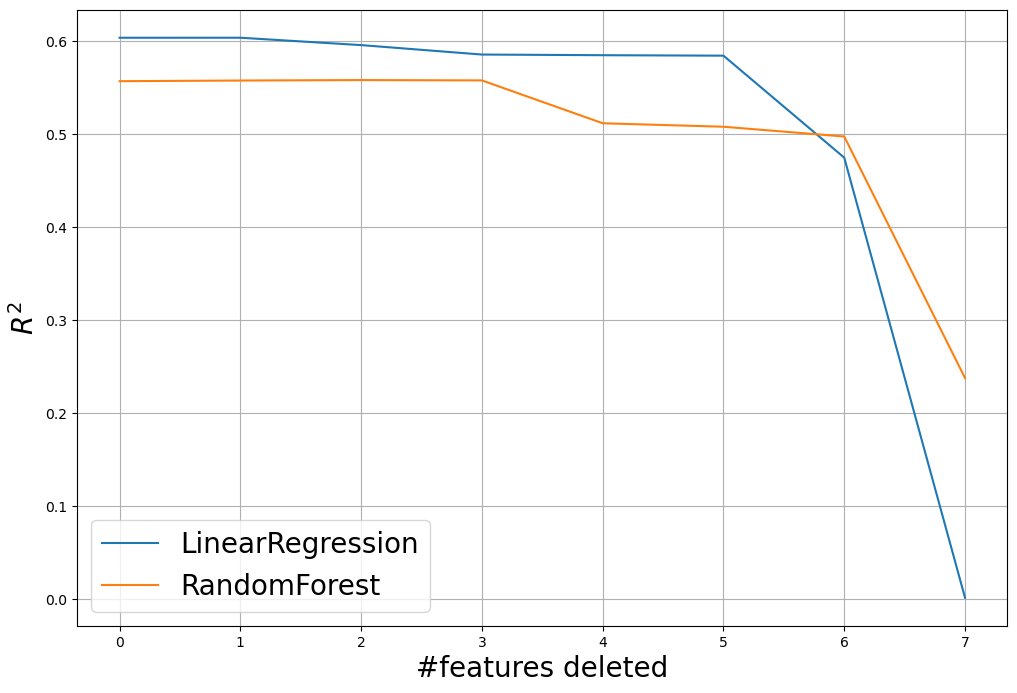

In [7]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Рекурсивный отбор

In [8]:
from sklearn.feature_selection import RFE

def scores_by_rfe(reg):
    scores = []
    for num_features in tqdm(np.arange(8,0,-1)):
        estimator = LinearRegression()
        selector = RFE(estimator, n_features_to_select=num_features, step=1)
        selector = selector.fit(X, y)

        X_part = selector.transform(X)
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_rfe(LinearRegression())
rf_scores = scores_by_rfe(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


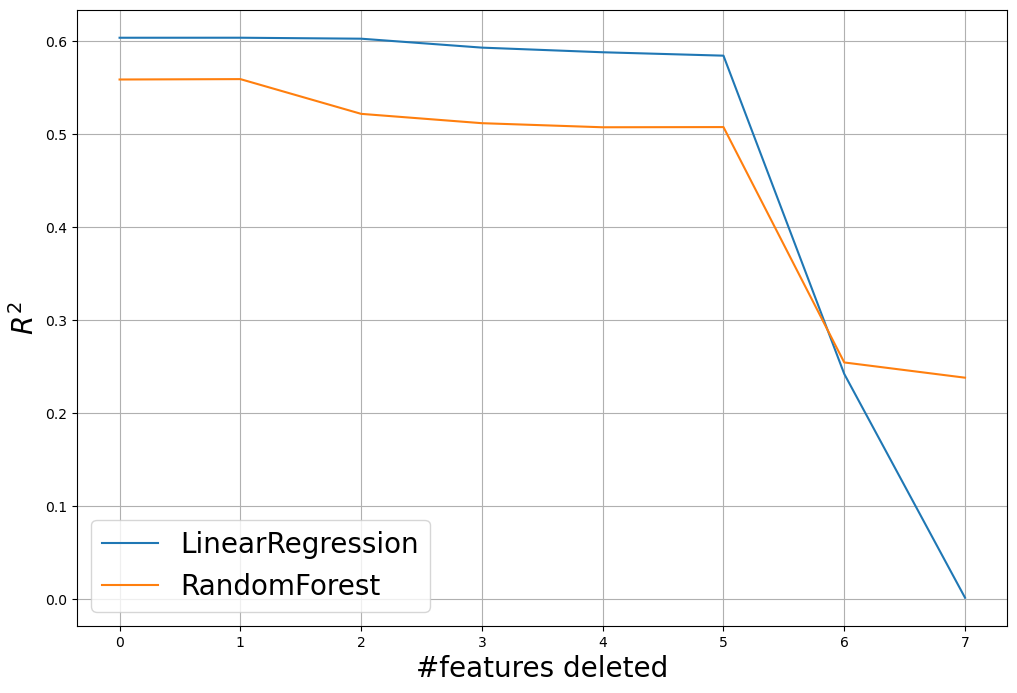

In [9]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Отбор по модели

In [10]:
from sklearn.feature_selection import SelectFromModel

estimator = LinearRegression()
selector = SelectFromModel(estimator)
selector = selector.fit(X, y)

importances_sort = np.argsort(selector.estimator_.coef_)

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


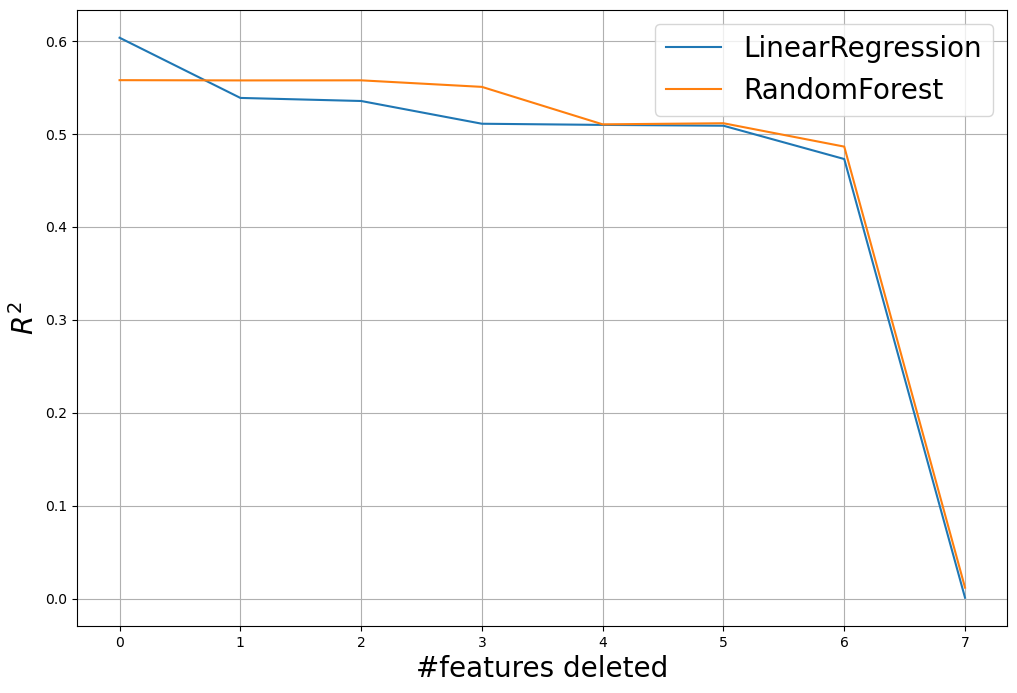

In [11]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

# 14.2 Метод главных компонент (Principal Components Analysis, PCA)

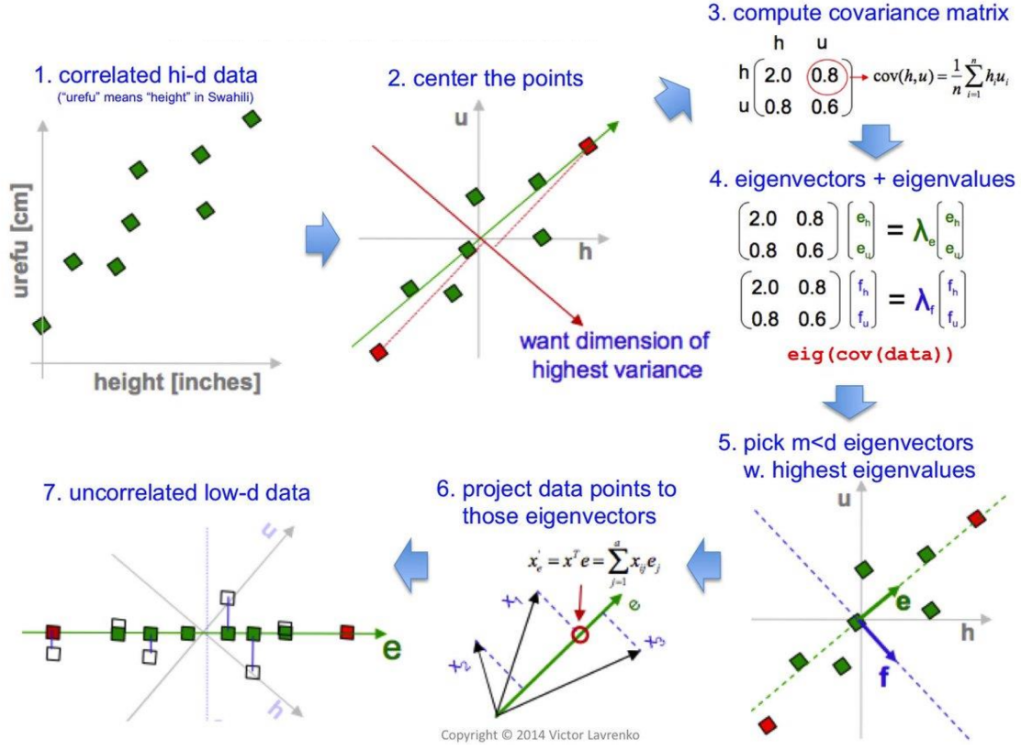

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

RANDOM_STATE = 42

Загружаем данные

In [13]:
diabetes = load_diabetes()
df = pd.DataFrame(data=diabetes.data,
                  columns=diabetes.feature_names)

df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641

Применяем PCA

Внутри метода данные уже центрированы

In [14]:
pca = PCA(n_components=10)

pca.fit_transform(df)

array([[ 0.02793021, -0.09260136,  0.02802565, ..., -0.03602731,
        -0.00861288, -0.00232845],
       [-0.13468668,  0.06526327,  0.00132849, ...,  0.008963  ,
         0.02402649,  0.00207377],
       [ 0.01294384, -0.07776432,  0.03516224, ..., -0.04010708,
        -0.00120593, -0.00257685],
       ...,
       [-0.00976067, -0.05733918,  0.02360117, ...,  0.02339486,
        -0.00538535,  0.00280039],
       [ 0.03295652,  0.00999473, -0.04132099, ..., -0.0037426 ,
        -0.00605083, -0.00216612],
       [-0.09056122,  0.18910841, -0.0022992 , ..., -0.0563818 ,
         0.03474513, -0.00735156]])

Вычисляем долю объясненной дисперсии

In [15]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

In [16]:
prop_var

array([0.40242108, 0.14923197, 0.12059663, 0.09554764, 0.06621814,
       0.06027171, 0.05365657, 0.0433682 , 0.007832  , 0.00085607])

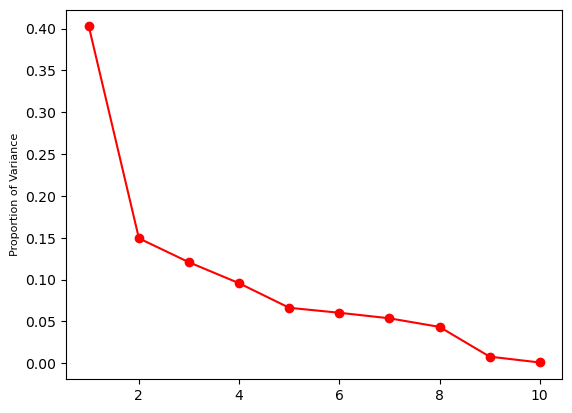

In [17]:
PC_numbers = np.arange(pca.n_components_) + 1

plt.plot(PC_numbers,
         prop_var,
         'ro-')
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

PCA для дальнейших задач

In [18]:
from sklearn.model_selection import train_test_split

X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

pca = PCA(n_components=5)
pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [19]:
X_train.shape, X_train_reduced.shape

((331, 10), (331, 5))

# 14.4 Визуализация данных при помощи t-SNE

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.manifold import TSNE

RANDOM_STATE = 42

Загрузим данные

In [21]:
from sklearn.datasets import load_digits

digits = load_digits()

pixel_data = digits.data
target = digits.target

pixel_data.shape

(1797, 64)

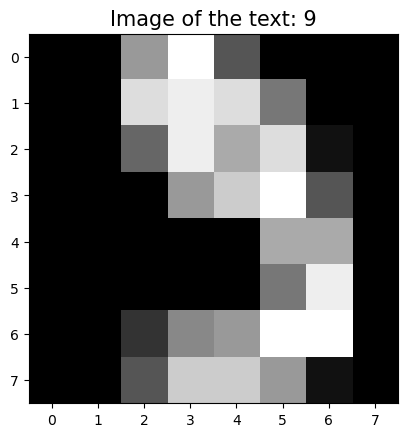

In [22]:
single_image = pixel_data[105, :].reshape(8,8)

plt.imshow(single_image, cmap='gray')
plt.title(f"Image of the text: {target[105]}", fontsize=15)
plt.show()

Будем делать визуализацию на плоскости (n_components = 2)

In [23]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)

x_transformed = tsne.fit_transform(pixel_data)

In [24]:
tsne_df = pd.DataFrame(np.column_stack((x_transformed, target)), columns=['X', 'Y', "Targets"])

tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype(int)

In [25]:
tsne_df.head(10)

X          Y  Targets
0  -3.335068 -56.418331      0.0
1  10.269802  12.005585      1.0
2 -13.776518  18.993013      2.0
3 -35.093025  -6.141835      3.0
4  41.463013   7.720223      4.0
5 -26.671852 -14.797441      5.0
6  33.246620 -14.147943      6.0
7   2.484659  41.202866      7.0
8 -14.255411   6.074697      8.0
9 -19.623457 -14.731346      9.0

Нарисуем результат

<Figure size 1000x800 with 0 Axes>

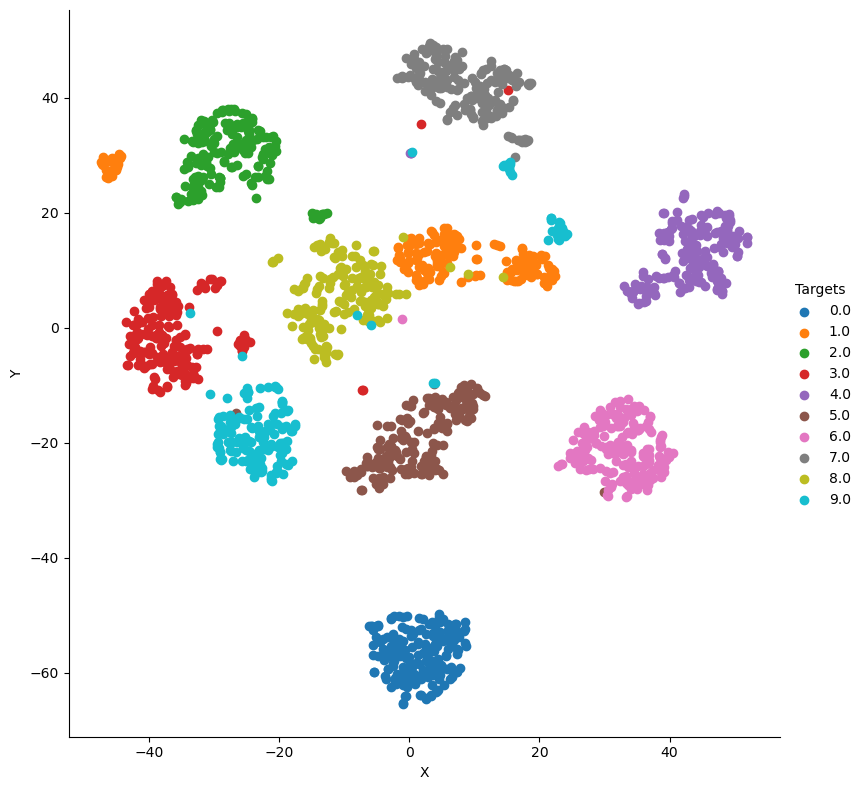

In [26]:
plt.figure(figsize=(10,8))

g = sns.FacetGrid(data=tsne_df, hue='Targets', height=8)

g.map(plt.scatter, 'X', 'Y').add_legend()

plt.show()

# Сжатие изображения без потери качества при помощи PCA

In [489]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 # conda install conda-forge::opencv

from scipy.stats import stats
from sklearn.decomposition import PCA

In [490]:
cv2.imread

<function imread>

Загрузим картинку и нарисуем ее в монохромный формат

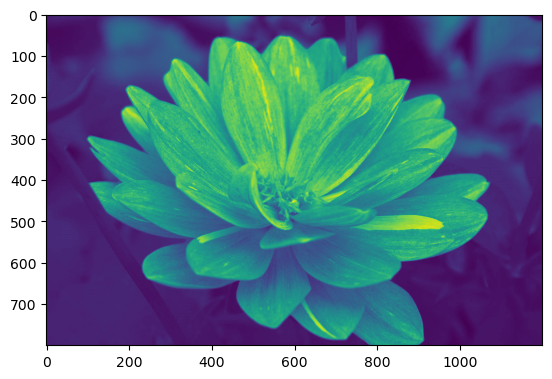

In [491]:
img = cv2.cvtColor(cv2.imread('data/flower.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

## Вопрос для Quiz

Какого размера картинка img? В ответе запишите общее число пикселей.

In [492]:
# ваш код здесь

img.shape[0] * img.shape[1]

960000

Посмотрим на матрицу изображения

In [493]:
img

array([[16, 16, 16, ..., 10, 10, 10],
       [16, 16, 16, ..., 10, 10, 10],
       [16, 16, 16, ..., 10, 10, 10],
       ...,
       [19, 19, 19, ..., 10, 10, 10],
       [19, 19, 19, ..., 10, 10, 10],
       [19, 19, 19, ..., 10, 10, 10]], dtype=uint8)

### Сейчас будем делать PCA

**Задание.** Масштабируйте данные, поделив значения в матрице на 255

In [494]:
# Ваш код здесь

img = img / 255
img

array([[0.0627451 , 0.0627451 , 0.0627451 , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.0627451 , 0.0627451 , 0.0627451 , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.0627451 , 0.0627451 , 0.0627451 , ..., 0.03921569, 0.03921569,
        0.03921569],
       ...,
       [0.0745098 , 0.0745098 , 0.0745098 , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.0745098 , 0.0745098 , 0.0745098 , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.0745098 , 0.0745098 , 0.0745098 , ..., 0.03921569, 0.03921569,
        0.03921569]])

**Задание.** Обучите PCA с 50-ю компонентами. Снизьте размерность.

In [495]:
from sklearn.decomposition import PCA
# Ваш код здесь

pca = PCA(n_components=50)
pca_trans = pca.fit_transform(img)

## Вопрос для Quiz

Выведите на экран долю дисперсии, объясняемой первыми 50-ю главными компонентами. Ответ округлите до сотых.

Вычисляем долю объясненной дисперсии

In [496]:
# Ваш код здесь
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

In [497]:
prop_var

array([4.60321311e-01, 1.45549817e-01, 9.59779298e-02, 4.63593079e-02,
       3.77067904e-02, 3.21227797e-02, 2.40573879e-02, 1.83444266e-02,
       1.48169213e-02, 1.35727687e-02, 1.02457044e-02, 9.11858430e-03,
       8.58837141e-03, 7.48180239e-03, 6.31101776e-03, 4.89480445e-03,
       4.48641147e-03, 3.92802037e-03, 3.54012114e-03, 3.14432640e-03,
       2.98864528e-03, 2.46653259e-03, 2.31777180e-03, 1.99333978e-03,
       1.95230994e-03, 1.75565662e-03, 1.70605310e-03, 1.58957450e-03,
       1.52232071e-03, 1.34542398e-03, 1.32035966e-03, 1.17721457e-03,
       1.10666540e-03, 9.89747501e-04, 9.60267697e-04, 9.11181776e-04,
       8.17695788e-04, 7.99527198e-04, 7.72418759e-04, 7.30120732e-04,
       7.15679914e-04, 6.79728118e-04, 6.08967288e-04, 5.85409775e-04,
       5.66955416e-04, 5.55434446e-04, 5.23042663e-04, 5.10155737e-04,
       4.97958354e-04, 4.54757659e-04])

**Задание.** Нарисуйте график, на котором отобразите долю дисперсии, объясняемой каждой из первых 50-ти компонент.

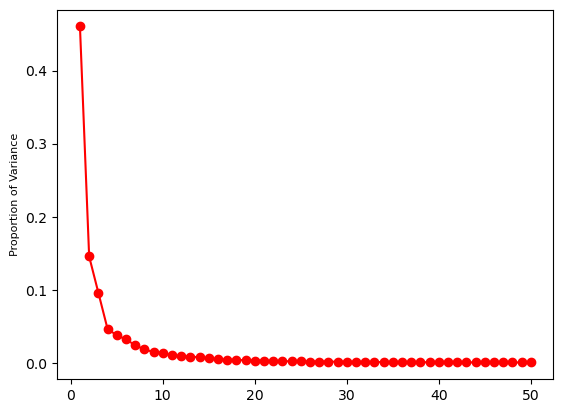

In [498]:
# Ваш код здесь

PC_numbers = np.arange(pca.n_components_) + 1

plt.plot(PC_numbers,
         prop_var,
         'ro-')
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show();

### Восстанавливаем изображение

**Задание.** Восстановите изображение, используя pca.inverse_transform.

In [499]:
# Ваш код здесь

img_restored = pca.inverse_transform(pca_trans)

In [500]:
img_restored.shape

(800, 1200)

In [501]:
np.sum(pca.explained_variance_ratio_)

0.98548952091045

**Задание.** Нарисуйте рядом два изображения: исходное и восстановленное (по своим 50 компонентам).

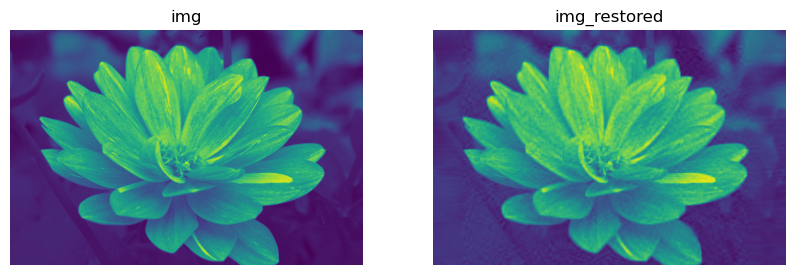

In [502]:
# Ваш код здесь
plt.figure(figsize=[10, 5])

plt.subplot(1, 2, 1)  # 1 rows, 2 columns, first position
plt.imshow(img)  
plt.axis('off')  # Hide the axis labels
plt.title('img') 

plt.subplot(1, 2, 2)  # 1 rows, 2 columns, second position
plt.imshow(img_restored)  
plt.axis('off')  # Hide the axis labels
plt.title('img_restored') 

plt.show();

## Вопрос для Quiz

Упало ли визуально качество при сжатии изображения до 50 главных компонент?

## Вопрос для Quiz

Подберите минимальное количество компонент, при которых сжатое изображение визуально практически не отличается от исходного. Подбор происходит перебором, ориентируемся на визуальный результат.

In [503]:
# Ваш код здесь

img_restored_list = []

for components in [50, 60, 75, 100]:
    pca = PCA(n_components=components)
    pca_trans = pca.fit_transform(img)
    img_restored = pca.inverse_transform(pca_trans)
    img_restored_list.append(img_restored)

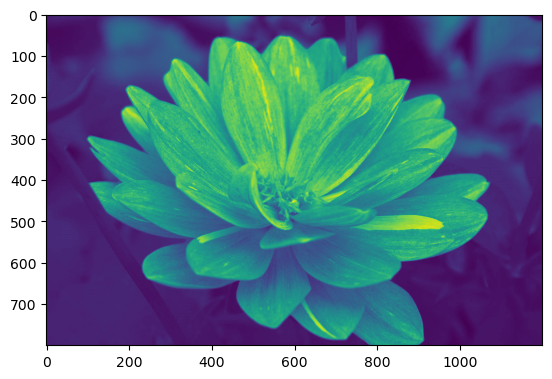

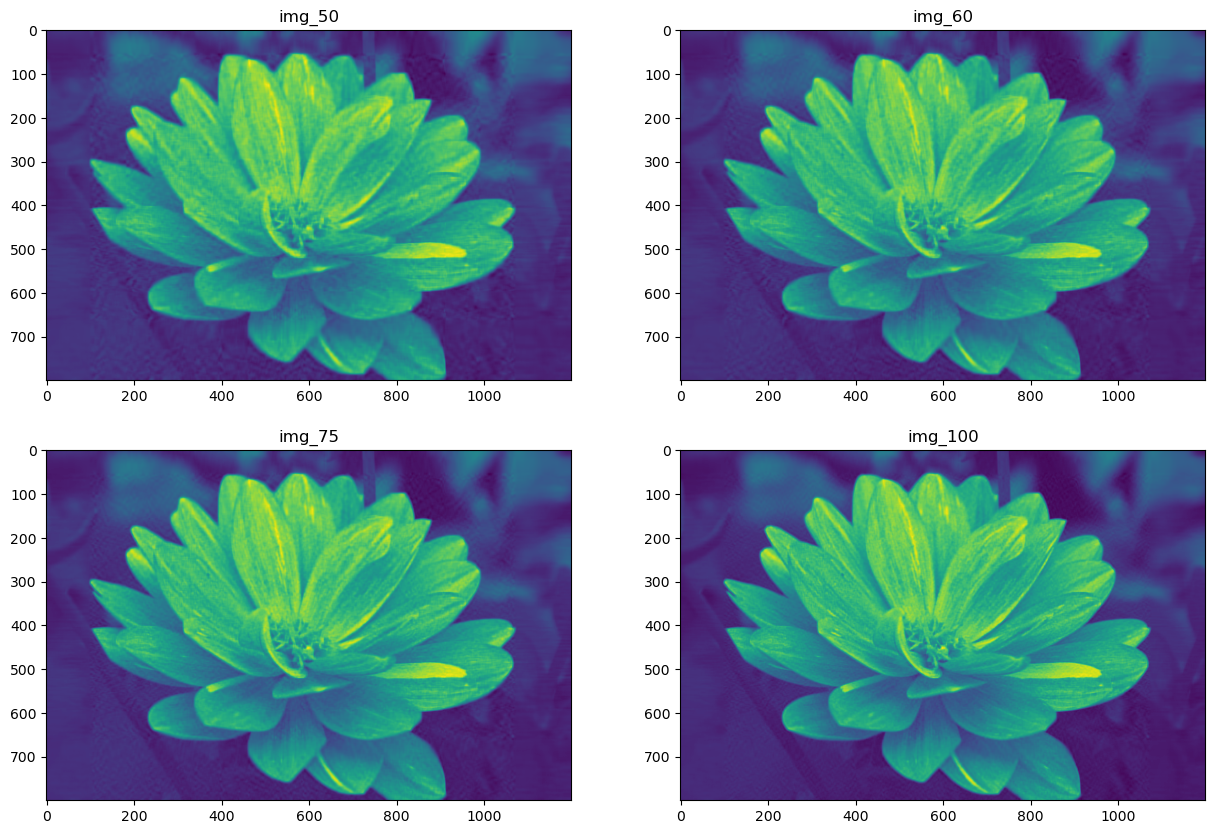

In [504]:
plt.imshow(img)
plt.show();

plt.figure(figsize=[15, 10])

plt.subplot(2, 2, 1)
plt.imshow(img_restored_list[0])  

plt.title('img_50') 

plt.subplot(2, 2, 2)
plt.imshow(img_restored_list[1])  

plt.title('img_60')

plt.subplot(2, 2, 3)
plt.imshow(img_restored_list[2])  
 
plt.title('img_75') 

plt.subplot(2, 2, 4)
plt.imshow(img_restored_list[3])  

plt.title('img_100') 

plt.show();

## Бонус

Попробуйте проделать все действия ноутбука, но уже с цветным изображением.

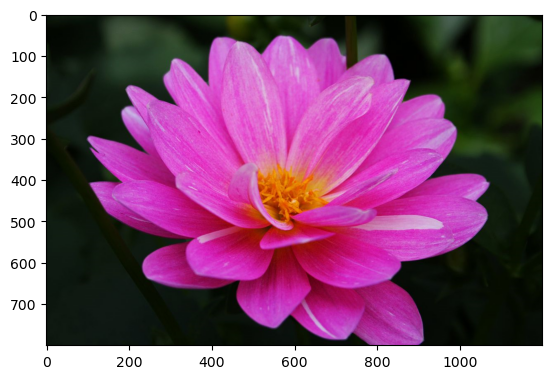

In [505]:
img = cv2.cvtColor(cv2.imread('data/flower.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Отличия от предыдущих шагов заключаются в том, что цветное RGB-изображение состоит из трех каналов - это матрица яркостей красного, матрица яркостей зеленого и матрица яркостей синего цветов.

Номер канала - последняя размерность в объекте `img`.
Например, матрица яркости красного - это `img[:,:,0]`.

Все действия выше нужно проделать с каждым каналом в отдельности, а потом объединить преобразованные изображения для каждого канала - чтобы получить итоговую картинку со сниженной размерностью.

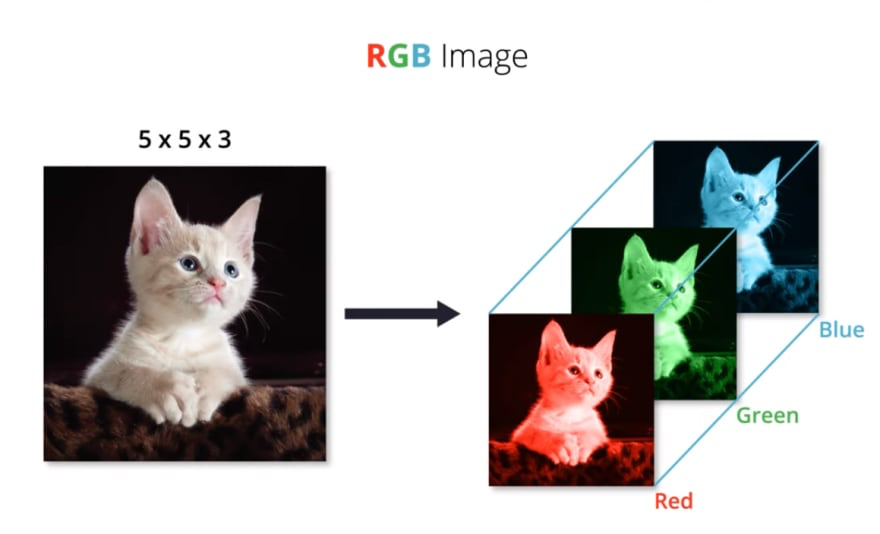

## Вопрос для Quiz

Найдите любое цветное изображение, которое вам нравится и снизьте его размерность, подберите минимальное число компонент, чтобы визуально не терять качество.

Вы можете снижать размерность для монохромного или для цветного изображения.

Результат - исходное изображение + его размеры, а также изображение после снижения размерности + число компонент.

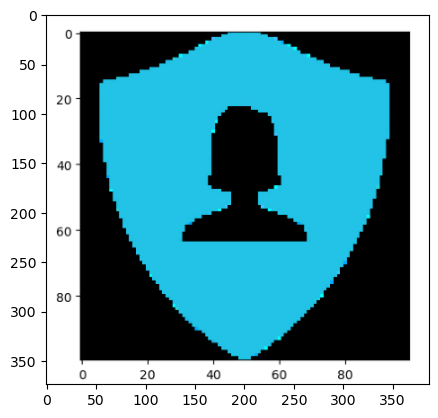

In [506]:
# ваш код здесь

# reading the image
img = cv2.cvtColor(cv2.imread('data/PCA-image.png'), cv2.COLOR_BGR2RGB)

# plotting the image using matplotlib
plt.imshow(img)
plt.show();

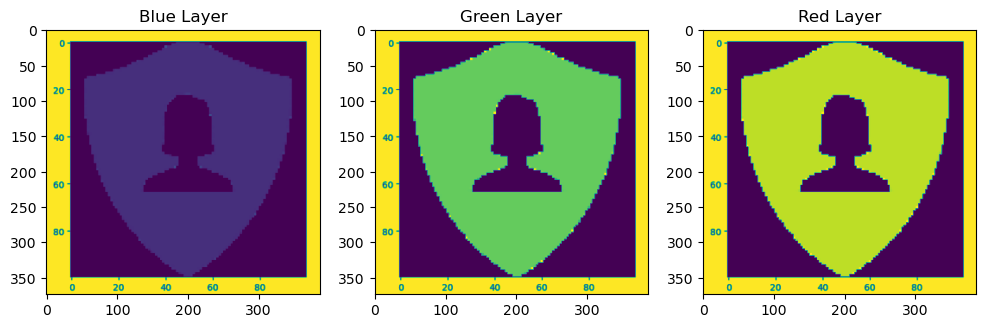

In [507]:
blue, green, red = cv2.split(img)


# fixing the size of image
fig = plt.figure(figsize = (12, 6))

# plotting blue color
fig.add_subplot(131)

# adding the title
plt.title("Blue Layer")
plt.imshow(blue)

# plotting green color
fig.add_subplot(132)

# adding the title
plt.title("Green Layer")
plt.imshow(green)

# plotting the red color
fig.add_subplot(133)

# adding the title
plt.title("Red Layer")
plt.imshow(red)
plt.show();

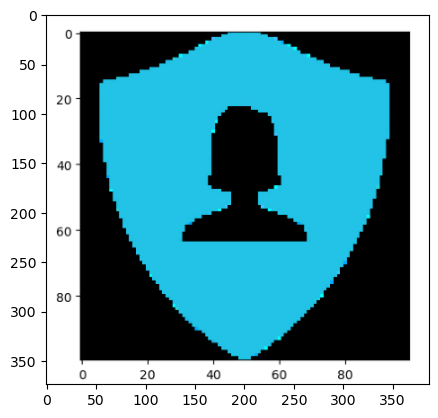

In [508]:
# merging to form RGB image
img_reduced = (cv2.merge((blue, green, red)))

plt.imshow(img_reduced)
plt.show();

In [509]:
# printing the shape 
print(red.shape)
print(green.shape)
print(blue.shape)

(374, 387)
(374, 387)
(374, 387)


In [510]:
# scalling the images
blue_img = blue / 255
green_img = green / 255
red_img = red / 255

In [511]:
# Reducing size with 40 components
pca = PCA(n_components=100)

# training on the  blue layer
pca.fit(blue_img)

# trainsforming the blue layer
trans_pca_b = pca.transform(blue_img)

# training on the  green layer
pca.fit(green_img)

# trainsforming the green layer
trans_pca_g = pca.transform(green_img)

# training on the  red layer
pca.fit(red_img)

# trainsforming the red layer
trans_pca_r = pca.transform(red_img)

In [512]:
# shape of reduced images
print(trans_pca_b.shape)
print(trans_pca_r.shape)
print(trans_pca_g.shape)

(374, 100)
(374, 100)
(374, 100)


In [513]:
# transforming back principal component analysis in Python
blue_arr = pca.inverse_transform(trans_pca_b)
green_arr = pca.inverse_transform(trans_pca_g)
red_arr = pca.inverse_transform(trans_pca_r)

In [514]:
# merging to form RGB image
img_reduced = cv2.merge((red_arr, green_arr, blue_arr))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6958170724610346..2.0681410743028343].


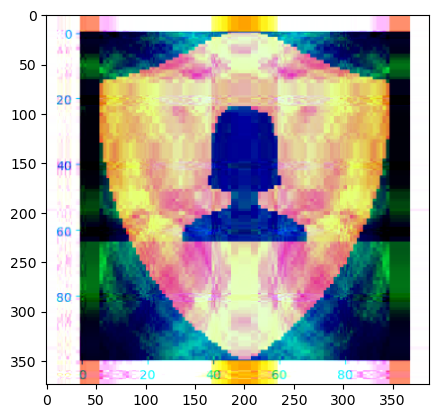

In [515]:
plt.imshow(img_reduced)
plt.show();

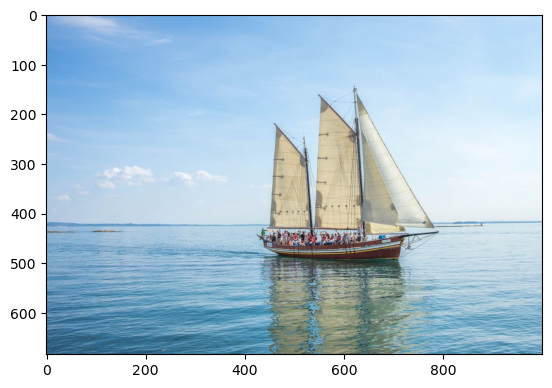

In [529]:
image_orig = cv2.cvtColor(cv2.imread('data/ship.jpg'), cv2.COLOR_BGR2RGB)

# plotting the image using matplotlib
plt.imshow(image_orig)
plt.show();

width = image_orig.shape[0]
height = image_orig.shape[1]
channels = image_orig.shape[2]

image = np.reshape(image_orig, (width, height*channels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18182770353103728..1.0760802618347978].


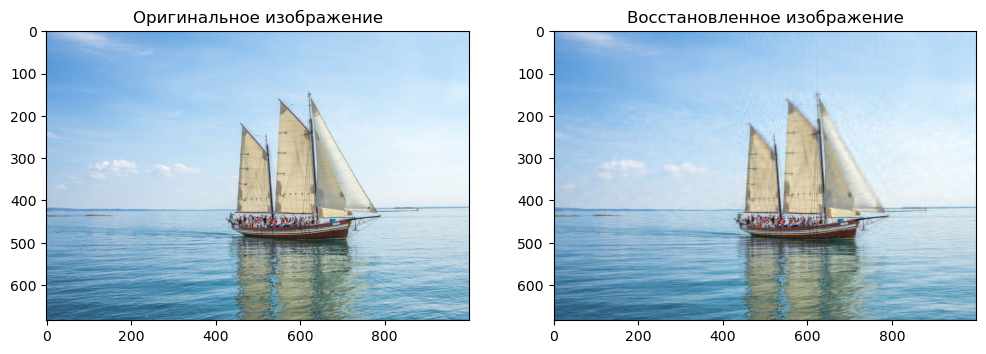

In [563]:
# Загрузка цветного изображения
img = cv2.cvtColor(cv2.imread('data/ship.jpg'), cv2.COLOR_BGR2RGB)

# Масштабирование изображения
scaled_img = img / 255.0

# Оригинальное количество компонент
original_components = scaled_img.shape[1]

# Задание количества компонент
n_components = 55

# Инициализация списка для хранения каналов
channels = []

# Перебор каналов по-отдельности
for i in range(scaled_img.shape[2]):
    
    # Выделение канала
    channel = scaled_img[:,:,i]
    
    # Обучение канала PCA с текущим количеством компонент
    pca = PCA(n_components=n_components)
    pca.fit(channel)

    # Сжатие и восстановление канала
    reduced_channel = pca.transform(channel)
    restored_channel = pca.inverse_transform(reduced_channel)
    
    # Добавление канала в список
    channels.append(restored_channel)

# Объединение каналов в цветное изображение
restored_image = cv2.merge(channels)


# Визуализация оригинального и восстановленного изображения
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Оригинальное изображение')
plt.imshow(scaled_img)

plt.subplot(1, 2, 2)
plt.title('Восстановленное изображение')
plt.imshow(restored_image)

plt.show();

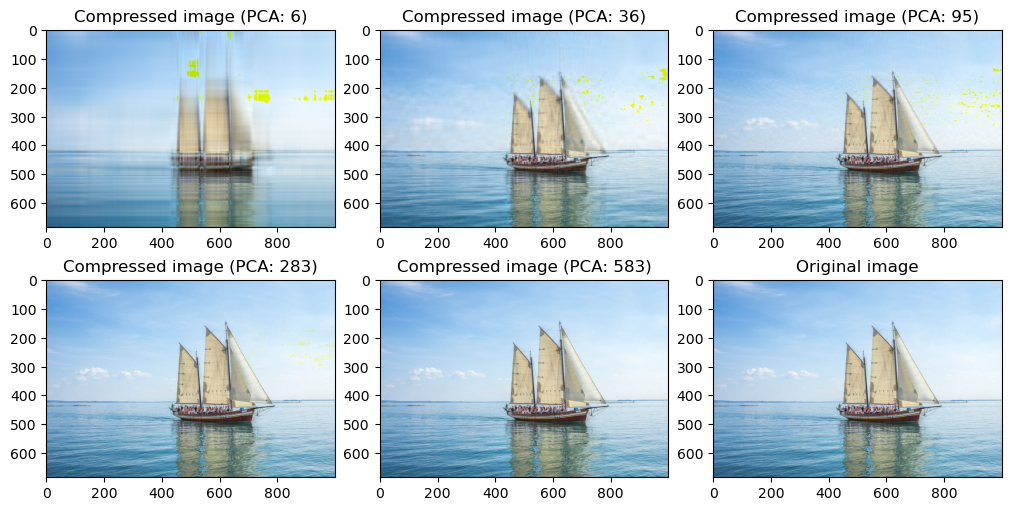

In [517]:
# Utility function that compresses image with given number
# of principal components
def compress_image(n_components, image, size):
    pca = PCA(n_components=n_components)
    image_compressed = pca.fit_transform(image)
    return pca.inverse_transform(image_compressed).reshape(size).astype('uint8')

# Compress images with different numbers of principal components
image_6 = compress_image(6, image, image_orig.shape)
image_36 = compress_image(36, image, image_orig.shape)
image_95 = compress_image(95, image, image_orig.shape)
image_283 = compress_image(283, image, image_orig.shape)
image_583 = compress_image(583, image, image_orig.shape)

fig, axes = plt.subplots(2,3, figsize=(10,5), constrained_layout=True)

axes[0][0].imshow(image_6)
axes[0][0].set_title("Compressed image (PCA: 6)")

axes[0][1].imshow(image_36)
axes[0][1].set_title("Compressed image (PCA: 36)")

axes[0][2].imshow(image_95)
axes[0][2].set_title("Compressed image (PCA: 95)")

axes[1][0].imshow(image_283)
axes[1][0].set_title("Compressed image (PCA: 283)")

axes[1][1].imshow(image_583)
axes[1][1].set_title("Compressed image (PCA: 583)")

axes[1][2].imshow(image_orig)
axes[1][2].set_title("Original image")

plt.show();